In [40]:
import os
import torch
import torchvision

import h5py
import deepdish as dd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import roc_auc_score

import tempfile
import time
import pickle as pkl

In [41]:
n_epochs = 50
patience_limit = 20
patience = 0
batch_size_train = 4# was 64
batch_size_test = 4
learning_rate = 0.001
momentum = 0.1
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000

model_path = './data/saved_models/' + 'mass_binary.pth'

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
''' 
    NOTES: 
    - it's "No Finding" not "No findings"
    - it's "Pleural_Thickening" not "Pleural_thickening"
    - it's not "Nodule Mass", but rather "Nodule" and "Mass" separately
'''
disease_map = {"Atelectasis" : 0, "Consolidation" : 1, "Infiltration" : 2, "Pneumothorax": 3, "Edema": 4,
               "Emphysema": 5, "Fibrosis": 6, "Effusion" : 7, "Pneumonia" : 8, "Pleural_Thickening" : 9,
               "Cardiomegaly" : 10, "Nodule" : 11, "Mass" : 12, "Hernia" : 13, "No Finding" : 14 }


In [4]:
class GetLoader(torch.utils.data.Dataset):
    '''
        Params: data - the data dictionary
                view - the orientation you want to look at
                diseases - the diseases you would like to look at
                num_imgs - the number of images of each disease you would like
                factor - the ratio of training and testing data
                typ - 0 for training, 1 for testing
    '''
    def __init__(self, data, view, diseases, num_imgs, factor, typ, transforms=None):
        
        #private data
        self.root = os.path.join('data/sorted_images',)
        self.data = data # dict object
        self.transforms = transforms
        self.len_data = 0
        datalist = []
        
        #Creating the datalist
        for i in range(len(diseases)):
            if len(data[view][diseases[i]]) <= num_imgs: #if the folder has less images than the desired number of images
                if typ == 0:
                    start = 0
                    end = int(len(data[view][diseases[i]])*factor)
                else:
                    start = int(len(data[view][diseases[i]])*factor)
                    end = -1
            else:
                if typ == 0:
                    start = 0
                    end = int(num_imgs*factor)
                else:
                    start = int(num_imgs*factor)
                    end = num_imgs
            datalist.append(self.data[view][diseases[i]][start:end])
        
        for item in datalist:
            self.len_data += len(item)
        
        
        self.img_paths = []
        self.img_labels = []
        
        for dis in datalist:
            for data in dis:
                #creating the image path
                data['img_path'] = os.path.join(self.root, data['classes'][0], view, data['img_name'])            
                diseases = data['classes']
                
                # TODO: we want the 1-hot vector for full-class net, not for 1 class net
                # what is below is very much hardcoded
                if data['classes'][0] != "No Finding":
                    label = 1
                else:
                    label = 0
                
                label = torch.Tensor([label])

#                 one_hot = [0] * 15
#                 hot_index = disease_map[data['classes'][0]]
#                 one_hot[hot_index] = 1
#                 data['label_tensor'] = torch.Tensor(one_hot)
                
                #modifying the attributes
                self.img_paths.append(data['img_path'])
                self.img_labels.append(label)
                # self.img_labels.append(data['label_tensor'])
            

    def __getitem__(self, item):
        
        img_path, img_label = self.img_paths[item], self.img_labels[item]
  
        # TODO: fix this hot fix -> recreate data object with underscore in name
        img_path = img_path.replace('No Finding', 'No_Finding')
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img_path = img_path.replace('/AP/', '/PA/')
            img = Image.open(img_path).convert('RGB')
        self.cur_img_path = img_path

        if self.transforms is not None:
            for t in self.transforms:
                img = t(img)

        return img, img_label
    
    def get_img_path(self):
        return self.cur_img_path

    def __len__(self):
        return self.len_data

In [5]:
class GetLoader_w_val(torch.utils.data.Dataset):
    '''
        NOTE: I hardcoded this one a bit, basically splits validation set in half and gives it to test set
    
        Params: data - the data dictionary
                view - the orientation you want to look at
                diseases - the diseases you would like to look at
                num_imgs - the number of images of each disease you would like
                factor - the ratio of training and testing data
                typ - 0 for training, 1 for testing
    '''
    def __init__(self, data, view, diseases, num_imgs, factor, typ, transforms=None):
        
        #private data
        self.root = os.path.join('data/sorted_images',)
        self.data = data # dict object
        self.transforms = transforms
        self.len_data = 0
        datalist = []
        
        #Creating the datalist
        for i in range(len(diseases)):                
            
            if len(data[view][diseases[i]]) <= num_imgs: #if the folder has less images than the desired number of images
                if typ == 0:
                    start = 0
                    end = int(len(data[view][diseases[i]])*factor)
                elif typ == 1:
                    start = int(len(data[view][diseases[i]])*factor)
                    end = int(len(data[view][diseases[i]])*factor + len(data[view][diseases[i]])*(1-factor) / 2)
                else:
                    start = int(len(data[view][diseases[i]])*factor + len(data[view][diseases[i]])*(1-factor) / 2)
                    end = -1
            else:
                if typ == 0:
                    start = 0
                    end = int(num_imgs*factor)
                elif typ == 1:
                    start = int(num_imgs*factor)
                    end = int(num_imgs*factor + num_imgs*(1-factor) / 2)
                else:
                    start = int(num_imgs*factor + num_imgs*(1-factor) / 2)
                    end = num_imgs
                    
            #print('dis: ', diseases[i], ', type: ', typ, ', start: ', start, ', end:', end)
            print('disease: ', diseases[i], 'num images used: ', min(len(data[view][diseases[i]]), num_imgs))
            datalist.append(self.data[view][diseases[i]][start:end])
        
        for item in datalist:
            self.len_data += len(item)
        
        
        self.img_paths = []
        self.img_labels = []
        
        for dis in datalist:
            for data in dis:
                #creating the image path
                data['img_path'] = os.path.join(self.root, data['classes'][0], view, data['img_name'])            
                diseases = data['classes']
                
                # TODO: we want the 1-hot vector for full-class net, not for 1 class net
                # what is below is very much hardcoded
                if data['classes'][0] != "No Finding":
                    label = 1
                else:
                    label = 0
                
                label = torch.Tensor([label])
                
                #modifying the attributes
                self.img_paths.append(data['img_path'])
                self.img_labels.append(label)
                # self.img_labels.append(data['label_tensor'])
            

    def __getitem__(self, item):
        
        img_path, img_label = self.img_paths[item], self.img_labels[item]
  
        # TODO: fix this hot fix -> recreate data object with underscore in name
        img_path = img_path.replace('No Finding', 'No_Finding')
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img_path = img_path.replace('/AP/', '/PA/')
            img = Image.open(img_path).convert('RGB')
        self.cur_img_path = img_path

        if self.transforms is not None:
            for t in self.transforms:
                img = t(img)

        return img, img_label
    
    def get_img_path(self):
        return self.cur_img_path

    def __len__(self):
        return self.len_data

### load in datasets

In [6]:
pkl_load = open('dataset.pickle', 'rb')
data = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [7]:
print(data['AP'].keys())

dict_keys(['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding'])


In [8]:
transforms = [torchvision.transforms.ToTensor()] # no longer grayscale conversion
#0 = train, 1 = test
dataset_train = GetLoader_w_val(data, orientation, ['Mass', 'No Finding'],
                          num_imgs, tt_factor, 0, transforms)
dataset_valid = GetLoader_w_val(data, orientation, ['Mass', 'No Finding'],
                          num_imgs, tt_factor, 1, transforms)
dataset_test = GetLoader_w_val(data, orientation, ['Mass', 'No Finding'],
                          num_imgs, tt_factor, 2, transforms)
print(len(dataset_train))
print(len(dataset_valid))
print(len(dataset_test))

disease:  Nodule num images used:  2154
disease:  No Finding num images used:  5000
disease:  Nodule num images used:  2154
disease:  No Finding num images used:  5000
disease:  Nodule num images used:  2154
disease:  No Finding num images used:  5000
5723
715
715


In [9]:
print(dataset_train[0][0][0])
print()
print(dataset_test[0][0][0])
print()
print(dataset_valid[0][0][0])

tensor([[0.0196, 0.0314, 0.0314,  ..., 0.0314, 0.0353, 0.0196],
        [0.0353, 0.0667, 0.0627,  ..., 0.0588, 0.0627, 0.0392],
        [0.0353, 0.0627, 0.0588,  ..., 0.0588, 0.0588, 0.0431],
        ...,
        [0.0392, 0.0706, 0.0745,  ..., 0.2627, 0.2902, 0.1804],
        [0.0196, 0.0353, 0.0353,  ..., 0.1176, 0.1333, 0.0824],
        [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0392, 0.0431, 0.0471],
        [0.0000, 0.0000, 0.0000,  ..., 0.0627, 0.0745, 0.0824],
        [0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.0706, 0.0745],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.8314, 0.7922, 0.6863],
        [0.0000, 0.0000, 0.0000,  ..., 0.4863, 0.4510, 0.4314],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

tensor([[0.1529, 0.2275, 0.1725,  ..., 0.0431, 0.0353, 0.0000],
        [0.2392, 0.3569, 0.2706,  ..., 0.0667, 0.0510, 0.0000],
        [0.2275, 0.3373, 0.2588,  ..., 0.0627, 0.0510, 0.0000],
        ..

In [10]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_train, shuffle=True, num_workers=1)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_train, shuffle=True, num_workers=1)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

1431
179
179


In [11]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [12]:
model.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=1, bias=True),
    nn.Sigmoid()
])
#model.children

In [13]:
network = model
#network = torchvision.models.vgg11(pretrained=False)
#network.fc = nn.Linear(512, 15)
network = torch.nn.DataParallel(network)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
print('Trainable params: {}'.format(sum(p.numel() for p in network.parameters() if p.requires_grad)))

Trainable params: 11177025


In [14]:
## source: https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d
def hard_binary_accuracy(batch, labels):
    batch = torch.round(batch)
    confusion_matrix = batch / labels
    
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_matrix = batch / labels
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_matrix == 1).item()
    false_positives = torch.sum(confusion_matrix == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_matrix)).item()
    false_negatives = torch.sum(confusion_matrix == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives


In [15]:
b = torch.Tensor([[[1, 1], [0, 0]], 
                  [[1, 1], [0, 0]]])

l = torch.Tensor([[[1, 1], [0, 0]], 
                  [[1, 1], [0, 0]]])
hard_binary_accuracy(b, l)

(4, 0, 4, 0)

In [16]:
def train(epoch):

    network.train()
    train_losses = []
    num_tested = 0
    net_loss = 0
    
    total_true_pos, total_false_pos, total_true_neg, total_false_neg = 0, 0, 0, 0
    
    for batch_idx, (data, target) in enumerate(train_loader):  # (output - actual )
        
        if torch.cuda.is_available:
            data, target = data.cuda(), target.cuda()

        output = network(data)
        
        criterion = torch.nn.BCELoss()  # 1 0 1 0 0 0 
        loss = criterion(output, target)
        loss.backward()
        
        net_loss += loss.detach().cpu().item()
        train_losses.append(loss.item())

        num_tested += len(data)
        
        #if True or batch_idx == len(train_loader) - 1:
        optimizer.step()
        optimizer.zero_grad()

        pred = output.detach().clone().cpu()
        target = target.cpu()

        true_pos, false_pos, true_neg, false_neg = hard_binary_accuracy(pred, target)
        total_true_pos += true_pos
        total_false_pos += false_pos
        total_true_neg += true_neg
        total_false_neg += false_neg
            
    net_loss /= (batch_size_train * len(train_loader))
    return net_loss, total_true_pos, total_false_pos, total_true_neg, total_false_neg


In [17]:
def test():
    
    network.eval()
    test_losses = []
    net_loss = 0    

    total_true_pos, total_false_pos, total_true_neg, total_false_neg = 0, 0, 0, 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if torch.cuda.is_available:
                data, target = data.cuda(), target.cuda()
            
            output = network(data)
            
            criterion = torch.nn.BCELoss()
            net_loss += criterion(output, target).item()

            pred = output.detach().clone().cpu()
            target = target.cpu()
            
            true_pos, false_pos, true_neg, false_neg = hard_binary_accuracy(pred, target)
            total_true_pos += true_pos
            total_false_pos += false_pos
            total_true_neg += true_neg
            total_false_neg += false_neg
            
        
    net_loss /= (batch_size_test * len(test_loader))
    return net_loss, total_true_pos, total_false_pos, total_true_neg, total_false_neg


In [18]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

1
GeForce RTX 2080 Ti
True


In [19]:
train_sample_size = len(train_loader) * batch_size_train
test_sample_size = len(test_loader) * batch_size_test
print(train_sample_size, test_sample_size)

5724 716


In [20]:
print("Starting Training...")
begin_time = time.time()

min_loss_test = 999

train_losses = []
test_losses = []

train_acc = []
test_acc = []

train_true_pos = []
train_false_pos = []
train_true_neg = []
train_false_neg = []

test_true_pos = []
test_false_pos = []
test_true_neg = []
test_false_neg = []

best_model_file = tempfile.NamedTemporaryFile(mode='w+b', delete=False)
torch.save(network.state_dict(), best_model_file.name)



for epoch in range(1, n_epochs + 1):
    start_time = time.time()
    network.load_state_dict(torch.load(best_model_file.name))

    loss_train, true_pos_train, false_pos_train, true_neg_train, false_neg_train = train(epoch)
    loss_test, true_pos_test, false_pos_test, true_neg_test, false_neg_test = test()
    
    print("tp / fp / tn / fn : ", true_pos_test, false_pos_test, true_neg_test, false_neg_test )
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    n_correct_train = true_pos_train + true_neg_train
    n_correct_test = true_pos_test + true_neg_test
    
    acc_train = 100. * n_correct_train / (train_sample_size )
    acc_test = 100. * n_correct_test / (test_sample_size)
    
    train_acc.append(acc_train)
    test_acc.append(acc_test)
    
    true_pos_rate_train = 100. * true_pos_train / (true_pos_train + false_pos_train)
    true_neg_rate_train = 100. * true_neg_train / (true_neg_train + false_neg_train)
    false_pos_rate_train = 100. * false_pos_train / (false_pos_train + true_neg_train)
    false_neg_rate_train = 100. * false_neg_train / (false_neg_train + true_pos_train)
    
    true_pos_rate_test = 100. * true_pos_test / (true_pos_test + false_pos_test)
    true_neg_rate_test = 100. * true_neg_test / (true_neg_test + false_neg_test)
    false_pos_rate_test = 100. * false_pos_test / (false_pos_test + true_neg_test)
    false_neg_rate_test = 100. * false_neg_test / (false_neg_test + true_pos_test)

    train_true_pos.append(true_pos_train)
    train_false_pos.append(false_pos_train)
    train_true_neg.append(true_neg_train)
    train_false_neg.append(false_neg_train)

    test_true_pos.append(true_pos_test)
    test_false_pos.append(false_pos_test)
    test_true_neg.append(true_neg_test)
    test_false_neg.append(false_neg_test)
        
    auc_train = roc_auc_score

        
    elapsed_time = time.time() - start_time
    
    print("-----------Epoch " + str(epoch) + " (time =", round(elapsed_time, 2), "s  aka  ", round(elapsed_time / 60, 2), " mins) ----------------")
    print('Train set: Avg. loss: {:.4f},  Accuracy: {}/{} ({:.2f}%)'.format(
        loss_train, n_correct_train, train_sample_size, acc_train))
    print('''
          True Positive: {:.2f}%
          True Negative: {:.2f}%
          False Positive: {:.2f}%
          False Negative {:.2f}%
          '''.format(true_pos_rate_train, true_neg_rate_train, false_pos_rate_train, false_neg_rate_train))    
    print('\nTest set:  Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        loss_test, n_correct_test, test_sample_size, acc_test))
    print('''
          True Positive: {:.2f}%
          True Negative: {:.2f}%
          False Positive: {:.2f}%
          False Negative {:.2f}%
          '''.format(true_pos_rate_test, true_neg_rate_test, false_pos_rate_test, false_neg_rate_test))
    
    
    if loss_test < min_loss_test:
        min_loss_test = loss_test
        patience = 0
        best_epoch = epoch
        
        print('Epoch {} --- saving new best model: test loss = {}'.format(epoch, loss_test))
        torch.save(network.state_dict(), best_model_file.name)
    else:
        patience += 1
        
    if patience == patience_limit:
        print('Breaking on patience={}'.format(patience))
        break


print('Reloading best model from epoch {}'.format(best_epoch))
network.load_state_dict(torch.load(best_model_file.name))

end_time = time.time() - begin_time

print("Training complete (time =", round(end_time, 2), "s)")
torch.save(network.state_dict(), 
           os.path.join(model_path))
print("Saved model to {}".format(model_path))

    

Starting Training...
tp / fp / tn / fn :  35 0 500 180
-----------Epoch 1 (time = 188.84 s  aka   3.15  mins) ----------------
Train set: Avg. loss: 0.1500,  Accuracy: 4001/5724 (69.90%)

          True Positive: 50.43%
          True Negative: 70.32%
          False Positive: 1.45%
          False Negative 96.58%
          

Test set:  Avg. loss: 0.1197, Accuracy: 535/716 (74.72%)

          True Positive: 100.00%
          True Negative: 73.53%
          False Positive: 0.00%
          False Negative 83.72%
          
Epoch 1 --- saving new best model: test loss = 0.11965277191646938
tp / fp / tn / fn :  25 0 500 190
-----------Epoch 2 (time = 182.66 s  aka   3.04  mins) ----------------
Train set: Avg. loss: 0.1439,  Accuracy: 4058/5724 (70.89%)

          True Positive: 62.18%
          True Negative: 71.29%
          False Positive: 2.25%
          False Negative 91.41%
          

Test set:  Avg. loss: 0.1105, Accuracy: 525/716 (73.32%)

          True Positive: 100.00%
         

In [39]:
print(50 / (50 + 82))
print(82  / (82 + 120))
print(88 / (88 + 82))
print(120 / (120 + 50))

0.3787878787878788
0.40594059405940597
0.5176470588235295
0.7058823529411765


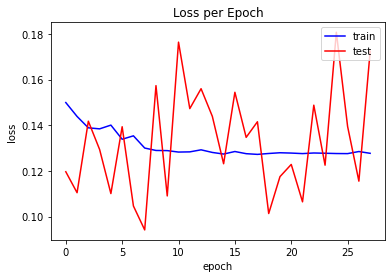

In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Loss per Epoch")
plt.plot(train_losses, "-b",  label="train")
plt.plot(test_losses, "-r", label="test")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")

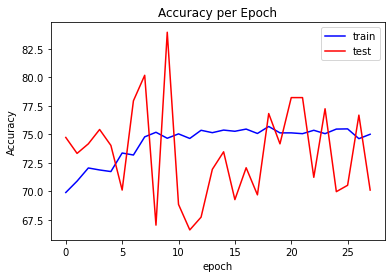

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Accuracy per Epoch")
plt.plot(train_acc, "-b", label="train")
plt.plot(test_acc, "-r", label="test")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")

In [30]:
preds = []
labels = []
for imgs, label in valid_loader:
    
    pred = network(imgs)
    pred = pred.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
    
    preds.append(pred)
    
    labels.append(label)

print("loaded all predictions with labels")

loaded all predictions with labels


In [31]:
import numpy as np
preds_np = np.array([])
labels_np = np.array([])
print(type(preds_np))
for p, l in zip(preds, labels):
    p = p.reshape(1, -1)
    l = l.reshape(1, -1)
    preds_np = np.append(preds_np, p)
    labels_np = np.append(labels_np, l)
print(preds_np.shape, labels_np.shape)

<class 'numpy.ndarray'>
(715,) (715,)


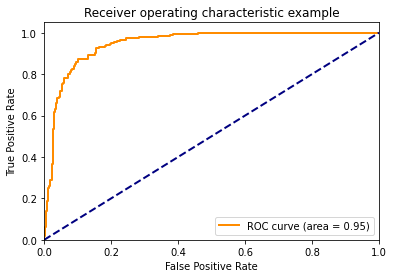

In [32]:
import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
y_test = labels_np
y_score = preds_np

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [38]:
import math

x = 0
y = 1

min_dist = 99
min_thresh = 0.5
mx = -1
my = -1

for x1, y1, t in zip(fpr, tpr, thresholds):
    dist = math.sqrt( (x - x1)**2 + (y - y1)**2 )
    if dist < min_dist:
        min_dist = dist
        min_thresh = t
        mx = x1
        my = y1
print("Best threshold: ", min_thresh)

Best threshold:  0.3208537697792053
